<a href="https://colab.research.google.com/github/viniciusbohn/data_science/blob/main/VBB_%5BPTBR%5D_Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Detecção de Fraudes em Cartões de Crédito**

## Introdução


Dentre os diversos casos de fraudes mais recorrentemente visualizados hoje em dia, destacam-se aqueles envolvendo cartões de crédito, em função da proporção do prejuízo que a a situação pode gerar, tanto para o consumidor quanto para a insituição financeira. Tendo conhecimento dessa situação, as empresas estão investindo significativamente em mecanismos de detecção de transações fraudulentas e o que melhor do que a Inteligência Artificial para isso?

<br>
<p align=center>
<img src="https://deliciouskitchenstories.com/wp-content/uploads/2022/02/shutterstock_223094779.jpg" width="50%"></p>
</br>

Com a quantidade de dados obtidos pelo histórico das transações do cartão de crédito, é possível desenvolver algoritmos de Machine Learning de alta eficiência e, assim, reduzir significativamente o impacto das fraudes. Mas é necessário muito cuidado ao desenvolver e implantar tal algoritmo, pois de nada adianta o mesmo ser efetivo contra operações fraudulentas mas bloquear preventivamente uma série de cartões sem necessidade (falsos positivos), gerando uma péssima experiência para os clientes verossímeis.

E é este o desafio deste projeto: desenvolver um algoritmo com o intuito de inibir ou evitar transações fraudulentas, de forma efetiva e com viabilidade real para negócios.

## Importando os Dados

Para a realização deste projeto serão utilizados dados de cartão de crédito de empresas européias. O *dataset* é composto pelos dados das operações financeiras realizadas através dos cartões e abrange um período de dois dias.

No período mencionado foram registradas quase 290 mil transações, sendo que destas, apenas uma quantidade muito baixa de operações foram classificadas como fraudes. Isso significa que estamos lidando com um conjunto de dados extremamente desbalanceado, visto que as fraudes representam apenas 0,17% do total de entradas.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3, \dots, V28]$ 

<br>
<p align=center>
<img src="https://w0.peakpx.com/wallpaper/124/992/HD-wallpaper-online-shopping-modern-technology-payment-online-e-commerce-business-concepts-credit-card-payment-laptop.jpg" width="50%"></p>
</br>

É importante salientar, também, que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA), conforme informado na [página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud). A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**. Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3, \dots, V28]$.

In [1]:
!pip install -q scikit-plot

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

sns.set_style('dark')

Agora que já instalamos os pacotes necessários e configuramos alguns parâmetros, vamos importar os dados para um DataFrame:

In [2]:
df = pd.read_csv("https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1")

O próximo passo é criarmos o conjunto de teste e de treino. Para o teste, criaremos um novo DataFrame composto por 15% das entradas do conjunto original, selecionados de forma aleatória, enquanto que, para o conjunto de treino, utilizaremos o DataFrame original decrescido das entradas utilizadas no conjunto de teste. Assim conseguimos testar e treinar o modelo evitando uma situação de Overfitting.

In [3]:
print("Dimensões do DataFrame Original: ", df.shape)

# Criação do DataFrame de Teste
test = df.sample(frac=0.15, random_state=0)

# Remoção das entradas de teste para utilização do DataFrame de Treino
df = df.drop(test.index)

print("Dimensões do DataFrame de Teste: ", test.shape)
print("Dimensões do DataFrame de Treino: ", df.shape)

Dimensões do DataFrame Original:  (284807, 31)
Dimensões do DataFrame de Teste:  (42721, 31)
Dimensões do DataFrame de Treino:  (242086, 31)


Certo, temos os dados divididos nos DataFrames necessários para desenvolvimento do modelo, podemos dar sequência no projeto. Inicialmente será feita uma breve análise exploratória dos dados, de forma a nos permitir visualizar de maneira prévia alguns comportamentos.

## Análise Exploratória Prévia

Vamos começar verificando as 5 primeiras entradas do dataset.

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ao avaliarmos as primeiras entradas podemos detectar alguns pontos interessantes:

*   A transformação PCA deixou as features descaracterizadas (anônimas) e em valores numéricos;

*   Apenas as colunas `Time` e `Amount` foram preservadas, mantendo seu valor original;

* A variável alvo está representada na coluna `Class`, onde:
    * **0:** Transação normal; e
    * **1:** Transação fraudulenta;

Vamos verificar agora o resumo estatístico do DataFrame.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,...,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000
mean,94857.597379,0.001456,-0.000800,-0.001004,0.000647,-0.000986,-0.001196,-0.000033,-0.000416,-0.000725,...,-0.000015,0.000606,-0.000482,0.000199,0.000048,-0.000269,-0.000727,0.000065,88.612429,0.001727
std,47490.660832,1.956513,1.654883,1.514580,1.417228,1.366284,1.326879,1.223095,1.199718,1.099350,...,0.734189,0.726284,0.629651,0.605150,0.521574,0.482084,0.401490,0.327734,247.655020,0.041517
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54234.000000,-0.920406,-0.598659,-0.893374,-0.848236,-0.693615,-0.769025,-0.553805,-0.208857,-0.645058,...,-0.228492,-0.542962,-0.161941,-0.354494,-0.316853,-0.327387,-0.070744,-0.052903,5.662500,0.000000
50%,84747.000000,0.019230,0.064567,0.177607,-0.018959,-0.054544,-0.274310,0.040344,0.022160,-0.051370,...,-0.028987,0.007162,-0.011175,0.040764,0.017175,-0.052337,0.001131,0.011209,22.000000,0.000000
75%,139362.000000,1.316034,0.803174,1.026561,0.743691,0.611455,0.397688,0.570104,0.327186,0.597195,...,0.187064,0.529814,0.147358,0.439320,0.350795,0.241214,0.090776,0.078234,77.580000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


Ao avaliarmos o resumo estatístico, não podemos detectar nenhuma discrepância aparente nas variáveis relativas aos componentes principais, transformadas pelo método PCA. O mesmo ocorre para as colunas `Time` e `Class`.

Já para a variável `Amount` é possível identificarmos algumas peculiaridades. Note que o valor mínimo é 0, ou seja, há transações registradas sem valor. Outro ponto a ser mencionado é que o valor máximo (19.656,53) é muito discrepante da mediana (22) e, inclusive, do terceiro quartil (77,58). O que é, de certa forma, esperado, já que a grande maioria das transações não engloba valores tão elevados.



Dando continuidade na nossa análise, vamos verificar a presença de valores ausentes no dataset:

In [6]:
df.isnull().sum().max()

0

Note que não há a presença de nenhum valor nulo no DataFrame, logo não será necessária nenhuma operação de limpeza.

Como mencionado anteriormente, a quantidade de entradas classificadas como fraudes, em relação ao volume total de transações, é muito baixa. Para quantificarmos isso, vamos verificar o percentual de transações fraudulentas e plotar um gráfico de barras para tornar mais fácil tal visualização.

0    241668
1       418
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



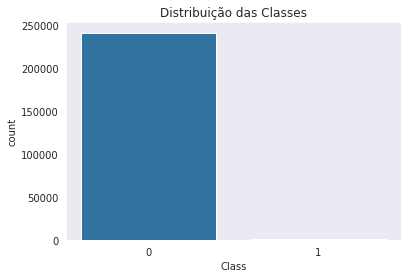

In [7]:
# ver o balanceamento das classes
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot();

Note a desproporcionalidade entre a quantidade de entradas no campo de classificação. Isso irá interferir diretamente no modelo, logo, para conseguirmos desenvolver um modelo de classificação eficiente, será necessária uma etapa prévia de balanceamento dos dados.

Mas antes disso, vamos analisar de forma mais aprofundada as variáveis `Time` e `Amount` em relação à classificação (`Class`), tendo em vista que isso pode nos trazer informações relevantes. Primeiramente vamos verificar a distribuição das transações normais e fraudulentas em relação ao tempo.

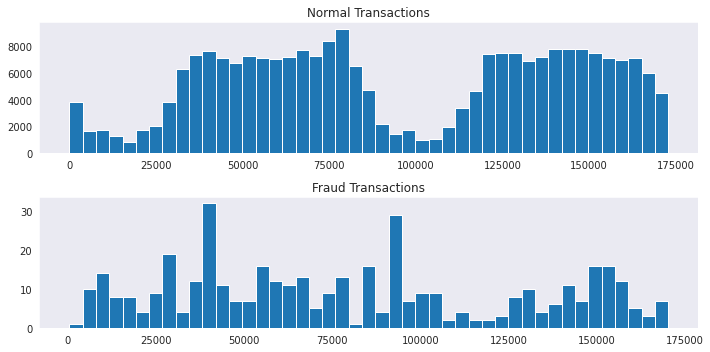

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

num_bins = 45

ax[0].hist(df.Time[df.Class==0], bins=num_bins)
ax[0].set_title('Normal Transactions');

ax[1].hist(df.Time[df.Class==1], bins=num_bins)
ax[1].set_title('Fraud Transactions');

plt.tight_layout()

Não foi possível extrair nenhuma informação relevante desta análise. Vamos verificar a distribuição das quantias das transações normais e fraudulentas utilizando a ferramenta *BoxPlot*.

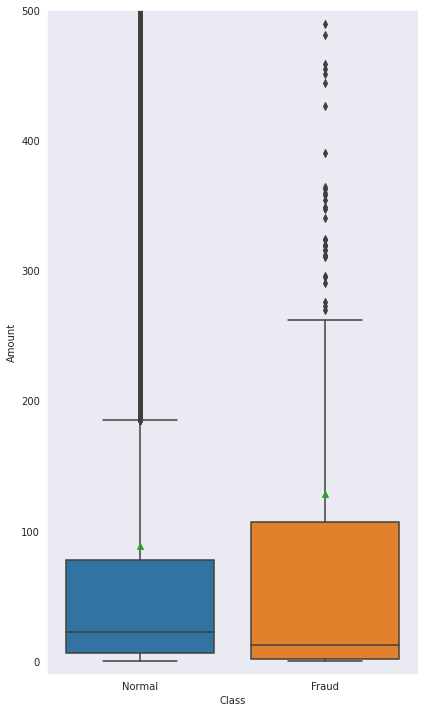

In [9]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-10, 500))
plt.xticks([0, 1], ['Normal', 'Fraud'])

plt.tight_layout()

Neste gráfico podemos verificar que há um diferença relevante na distribuição da variável `Amount` dentre as transações normais e fraudes. Essa variável provavelmente irá nos ajudar no treinamento do modelo de classificação nas próximas etapas.

Para finalizar essa análise prévia, vamos gerar os gráficos de densidade para as variáveis, divididas entre as entradas de transações normais e fraudulentas.

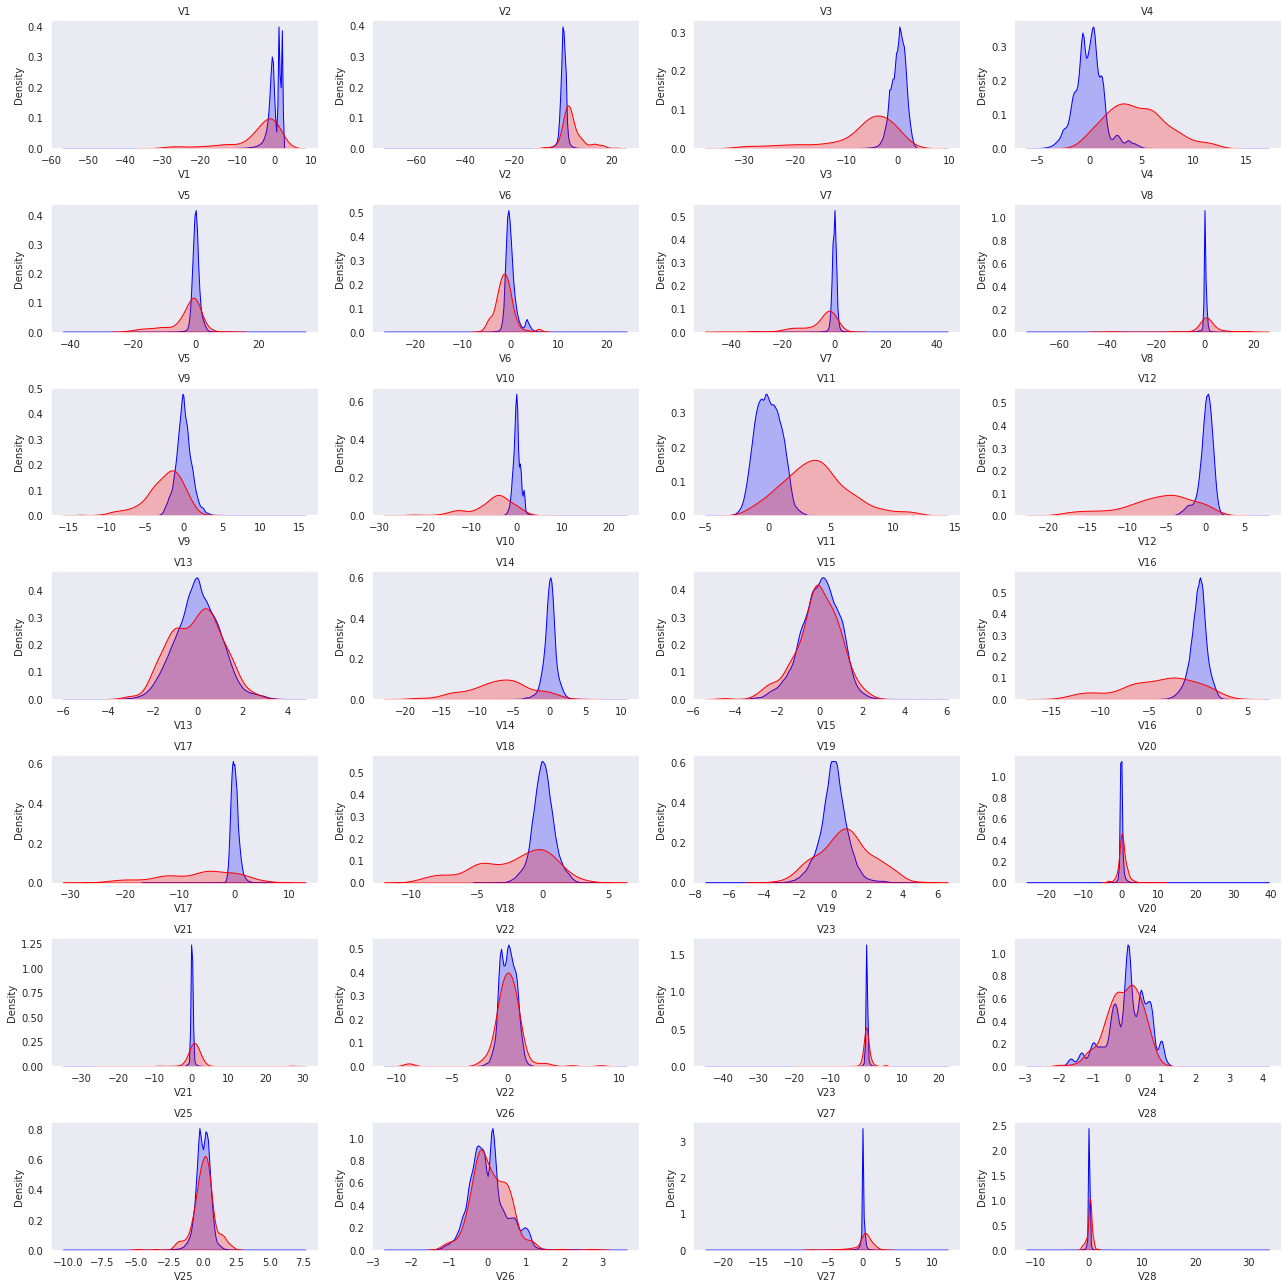

In [10]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class0 = df[df.Class == 0]
df_class1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
  idx += 1
  plt.subplot(7, 4, idx)
  sns.kdeplot(df_class0[col], label="Class 0", color='blue', shade=True)
  sns.kdeplot(df_class1[col], label="Class 1", color='red', shade=True)
  plt.title(col, fontsize=10)

plt.tight_layout()

É possível identificar comportamentos diferentes para uma série de variáveis, por exemplo: **V12, V14, V17, etc.** Enquanto outras variáveis possuem distribuição similar para casos normais e de fraudes: **V15, V23, V28, etc.**

São as variáveis com distribuições diferentes entre as transações normais e fraudulentas que nos permitiram desenvolver o modelo de classificação.


## Preparação dos Dados

Aqui faremos a preparação dos dados para posterior desenvolvimento do modelo de Machine Learning. Esta etapa consiste da divisão do conjunto de dados entre treino e validação, balanceamento dos dados e a normalização das variáveis `Time` e `Amount`.

### **Normalização das variáveis `Time` e `Amount`**

Conforme identificamos durante nossa análise exploratória, as variáveis `Time` e `Amount` não foram pré-processadas e, portanto, devemos normalizar seus respectivos dados antes de darmos sequência no desenvolvimento do modelo. Para tal operação, será realizada a padronização através da classe `StandardScaler`.

In [11]:
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.246341,-1.997399
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.346945,-1.997399
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.171178,-1.997378
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140872,-1.997378
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075195,-1.997357


Note que criamos duas novas colunas `std_amount`, referente à quantia (`Amount`) padronizada, e `std_time`, referente ao tempo padronizado. Além de padronizar a ordem de grandeza com as demais variáveis, remove os *outliers* que detectamos anteriormente na variável `Amount`.

Note também que removemos as colunas originais, `Amount` e `Time`.

### **Divisão dos Dados: Treino e Validação**

Para podermos avançar à etapa de balanceamento dos dados, precisamos, primeiramente, separar os dados nos conjuntos de treino e validação. É essencial que isso seja feito antes do balanceamento, assim temos os parâmetros para verificarmos se os dados estão balanceados de forma adequada.

In [12]:
X = df_clean.drop('Class', axis=1)
y = df.Class

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True)

Agora separamos os dados em quatro novos conjuntos, sendo os DataFrames `X_train` e `Y_train` utilizados para treinamento do modelo e `X_val` e `Y_val` responsáveis pela validação do modelo. Os conjuntos referenciados por "X" (`X_train` e `X_val`) são compostos por todas as variáveis do DataFrame original, exceto `Class`, enquanto os conjuntos referenciados por "Y" (`Y_train` e `Y_val`) são compostos apenas pelas entradas da variável de classificação, `Class`. 





### **Balanceamento dos Dados**

Temos os dados separados nos conjuntos de treino e validação, podemos prosseguir com a etapa de balanceamento dos dados. Para essa situação optou-se por utilizar o método *Under-Sampling*, que consiste em balancear os dados preservando a classe minoritária que, no nosso caso, é a de fraudes `[Class == 1]`.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

Esse método criou dois novos conjuntos, a partir dos dados de treino, com o balanceamento adequado entre as classes. Note que o conjunto `y_rus` está com exatamento 313 entradas classificadas como transações normais e o mesmo valor para transações fraudulentas.

In [14]:
print(y_rus.value_counts())

0    313
1    313
Name: Class, dtype: int64


Outro fator interessante é que, agora com os dados balanceados, podemos plotar a matriz de correlação e identificar quais variáveis estão mais relacionadas com as outras. Vamos verificar a matriz de correlação dos dados não-balanceados e balanceados, para evidenciar a diferença.

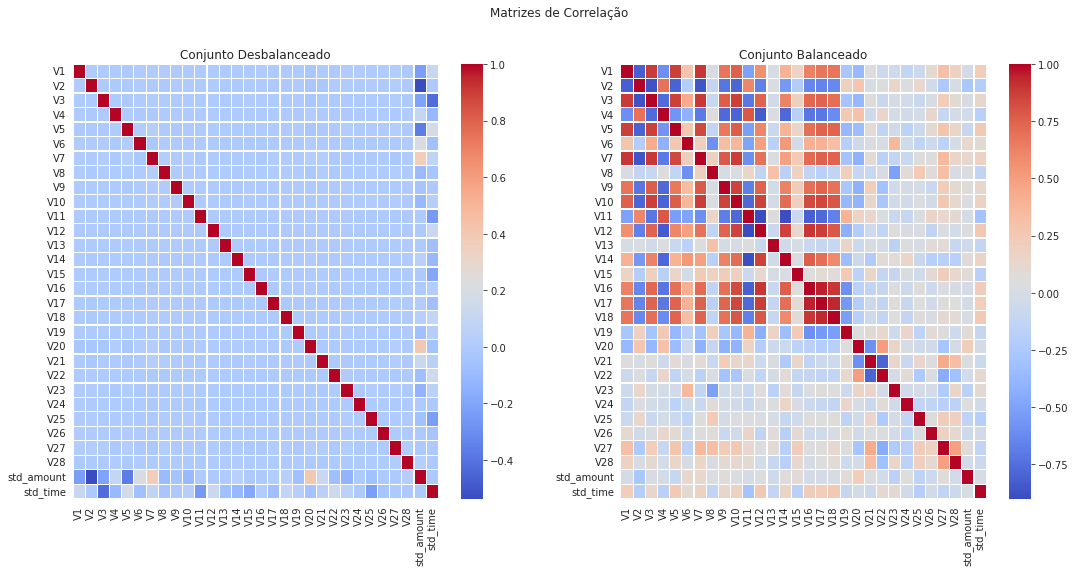

In [15]:
corr = X_train.corr()
corr_rus = X_rus.corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle("Matrizes de Correlação")

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Conjunto Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr_rus.columns, yticklabels=corr_rus.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Conjunto Balanceado')

plt.show()

Veja como a matriz dos dados desbalanceados não nos traz muita informação relevante, enquanto a matriz de correlação dos dados balanceados nos permite identificar relações muito fortes entre diversas variáveis.

Agora com a preparação dos dados concluída, podemos dar início a construção do modelo de Machine Learning para classificação das transações.

## Modelo de Machine Learning

Para criação do nosso modelo de classificação, utilizaremos a Regressão Logística. Na fase de treinamento utilizaremos os conjuntos de dados balanceados `X_rus` e `y_rus`.

In [16]:
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

Certo, já fizemos o treinamento do modelo e as previsões. A próxima etapa é a avaliação de desempenho do nosso modelo de classificação.

A primeira ferramenta que utilizaremos para avaliação do desempenho é a matriz de confusão.

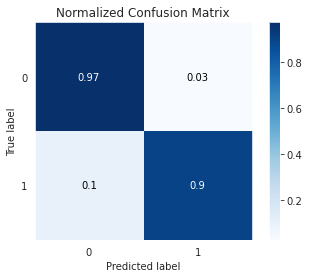

In [17]:
skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True);

A matriz de confusão é uma ferramenta muito interessante. De maneira resumida, ela nos apresenta a taxa de acertos para Verdadeiros Positivos (97%) e Verdadeiros Negativos (90%) que no nosso caso significariam, respectivamente, que temos 97% de taxa de acerto em reconhecer transações Normais e 90% de taxa de acerto em reconhecer transações Fraudulentas.

Ela também nos apresenta o percentual de Falsos Positivos (3%) e de Falsos Negativos (10%). Isso significa que o modelo previu incorretamente 10% das fraudes como transações normais e 3% das transações normais como fraudes.

Agora vamos verificar o relatório de classificação. Importante salientar que, para casos como o nosso, em que os dados estavam originalmente desbalanceados, não devemos avaliar o desempenho através da acurácia, a fim de evitar o Paradoxo da Acurácia.

In [18]:
print("Relatório de Classificação:\n", classification_report(y_val, y_pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9673    0.9833     60417
           1     0.0458    0.9048    0.0873       105

    accuracy                         0.9672     60522
   macro avg     0.5228    0.9360    0.5353     60522
weighted avg     0.9982    0.9672    0.9817     60522



Ao avaliarmos a coluna `recall` do nosso relatório de classificação, temos os mesmos resultados apresentados na matrix de confusão, referente às taxas de acerto de transações normais e fraudulentas.

Para finalizar a análise de desempenho, vamos utilizar a métrica **AUC ROC**, ou área sob a curva. A curva ROC mostra o quão bom o modelo criado pode distinguir entre duas coisas (já que é utilizado para classificação) e, por sua vez, o valor AUC nada mais é do que uma forma de representar a curva ROC em um único valor numérico. Quanto mais próximo de 1.0 melhor a eficácia de nosso modelo.

In [19]:
print("AUC: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))

AUC: 0.9360



O AUC de nosso modelo de classificação ficou bem alto (0,93 ou 93%), uma ótima eficácia.

## Simulação com Conjunto de Teste

Agora que fizemos as avaliações de desempenho, utilizando os dados de validação, chegou a hora de utilizar nosso modelo com os dados de teste, que separamos em um DataFrame logo no início do projeto.

Importante relembrarmos que o conjunto de teste não passou pelas etapas de preparação dos dados, logo, para termos uma comparação adequada, precisamos realizar alguns ajustes no *dataset*. Neste conjunto iremos apenas padronizar as colunas `Time` e `Amount`, não realizando o balanceamento dos dados. Para essa situação queremos simular uma condição "real" de proporção.

In [20]:
test_clean = test.copy()

std_scaler = StandardScaler()
test_clean['std_amount'] = std_scaler.fit_transform(test_clean['Amount'].values.reshape(-1, 1))
test_clean['std_time'] = std_scaler.fit_transform(test_clean['Time'].values.reshape(-1, 1))

test_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

test_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


In [21]:
X_test = test_clean.drop('Class', axis=1)
y_test = test['Class']

y_pred2 = model.predict(X_test)
y_proba2 = model.predict_proba(X_test)

Vamos ver como foi o desempenho do modelo na classificação dos dados de teste:

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9688    0.9841     42647
           1     0.0507    0.9595    0.0963        74

    accuracy                         0.9688     42721
   macro avg     0.5253    0.9641    0.5402     42721
weighted avg     0.9983    0.9688    0.9826     42721

AUC: 0.9641



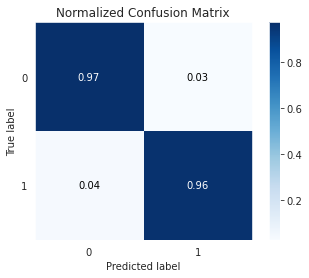

In [22]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred2, normalize=True);

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred2, digits=4))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred2)))

Note que o desempenho do modelo de classificação foi extremamente eficiente, apresentando um valor **AUC** ainda maior do que o obtido com os dados de validação.

## Conclusão

Mesmo tratando-se de um processo complexo, esse projeto evidencia a eficiência com que os modelos de Machine Learning são capazes de operar e, dessa forma, agregar imenso valor para os mais diferentes segmentos de negócios. Utilizando como referência os resultados da simulação com os dados de teste, a aplicação deste modelo representaria uma redução de 92% de transações fraudulentas. O impacto financeiro e o melhoria na experiência do cliente são muito significativos.

<br>
<p align=center>
<img src="https://www.cio.com/wp-content/uploads/2021/12/data_analytics_risk_assessment_tracking_trends_graphs_by_ipopba_gettyimages-1150397416_2400x1600-100828857-orig-6.jpg?quality=50&strip=all&w=1024" width="50%"></p>
</br>